# Sub-genre Analysis: Analyze the subgenres of the *everynoise* network

In [2]:
# Imports
import numpy as np
import pandas as pd 
import networkx as nx
import community
import ast
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


## Load the Data

In [3]:
df_allG = pd.read_csv('all_genres.csv')
df_allG.head()

Unnamed: 0               GENRE  \
0           0     backgroundmusic   
1           1  classicmoroccanpop   
2           2       orthodoxchant   
3           3                 tar   
4           4              reggae   

                                          SIM_GENRES  \
0  ['reiki', 'calminginstrumental', 'yoga', 'back...   
1  ['bluesrock', 'andalusianclassical', 'chaabima...   
2  ['universitychoir', 'polishchoir', 'ukrainianc...   
3  ['oud', 'persiantraditional', 'bansuri', 'tar'...   
4  ['dancehall', 'brazilianreggae', 'skarevival',...   

                                         SIM_WEIGHTS  \
0  ['103', '120', '101', '240', '102', '125', '11...   
1  ['103', '107', '109', '100', '102', '103', '10...   
2  ['102', '105', '107', '104', '106', '240', '10...   
3  ['106', '120', '101', '240', '103', '113', '10...   
4  ['109', '105', '114', '101', '100', '127', '11...   

                                          OPP_GENRES  \
0  ['mahraganat', 'divahouse', 'oldschoolukhiphop...   
1  ['shiverpop', 'gravewave', 'tassieindie', 'est...   
2  ['sambass', 'funkybreaks', 'hardbass', 'hardco...   
3  ['happyhardcore', 'aggrotech', 'nightcore', 'b...   
4  ['brazilianlo-firock', 'martialindustrial', 'p...   

                                         OPP_WEIGHTS  \
0  ['160', '100', '121', '110', '135', '136', '12...   
1  ['112', '112', '105', '102', '124', '100', '16...   
2  ['107', '110', '158', '100', '119', '111', '10...   
3  ['109', '107', '127', '114', '115', '120', '12...   
4  ['106', '107', '155', '121', '160', '108', '14...   

                                         REL_ARTISTS  \
0  ['NoemiNucci', 'JuditheAbelsen', 'FabienneWill...   
1  ['HajHusseinToulali', 'AbdelhadiBelkheyat', 'H...   
2  ['LegeArtis', 'PeterMichaelides', 'CapellaGreg...   
3  ['KiyarashSaket', 'YusefForutan', 'HamidMoteba...   
4  ['TheItals', 'MykalRose', 'JohnnieClark', 'Asw...   

                                      ARTIST_WEIGHTS  \
0  ['113', '117', '106', '131', '109', '115', '11...   
1  ['102', '103', '103', '108', '108', '102', '10...   
2  ['114', '100', '160', '127', '115', '115', '10...   
3  ['100', '100', '111', '100', '100', '100', '10...   
4  ['101', '102', '100', '105', '101', '105', '10...   

                                         SPOTIFY_URL  
0  https://open.spotify.com/user/thesoundsofspoti...  
1  https://open.spotify.com/user/thesoundsofspoti...  
2  https://open.spotify.com/user/thesoundsofspoti...  
3  https://open.spotify.com/user/thesoundsofspoti...  
4  https://open.spotify.com/user/thesoundsofspoti...

## Construct the Weighted Graph based on Similar Genres where $\vert SIM\_GENRES \vert > n$
Where $n$ is the number of edges / connections for a genre.

### Functions

In [18]:
'''
df: Dataframe
support: The minimum number of connections a node must have to be incorporated into the set of genres

Useful for checking the genres that have over <support> connections.
'''
def set_genre(df, support: int = -1):
    set_genres = set()
    for idx, row in df.iterrows():
        connections = ast.literal_eval(row['SIM_GENRES'])
        
         # Only add the (node,edges) into the set if the number of connections is greater than the support
        if len(connections) > support:
            set_genres.add(row['GENRE'])
            set_genres.update(connections)
    return (support, set_genres)

'''
df: Dataframe
support: The minimum number of connections a node must have to be incorporated into the graph
n: The number of rows to traverse on the Dataframe (only useful for testing)
'''
def generate_G(df, support: int = -1, n: int = 5000):
    G = nx.Graph()
    for idx, row in df.iterrows():
        connections = ast.literal_eval(row['SIM_GENRES'])
        weights = ast.literal_eval(row['SIM_WEIGHTS'])
        
        # Only add the (node,edges) if the number of connections is greater than the support
        if len(connections) > support:
            G.add_node(row['GENRE'])
            edges = [(row['GENRE'], connections[i], int(weights[i])) for i in range(len(connections))]
            G.add_weighted_edges_from(edges)
            
        # Useful if you only need a small sample (for testing mainly)
        if idx == n:
            break
    return G

def plot_network(G, set_genres):
    plt.rcParams['figure.dpi'] = 300

    fig, ax = plt.subplots(1, figsize = (16,9))

    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, nodelist = list(set_genres), node_size = 20, alpha = 1)
    nx.draw_networkx_edges(G, pos, width = 1.0, alpha = 1, connectionstyle = 'arc3, rad=1')
#     labels = nx.draw_networkx_labels(G, pos, font_size = 3)

    ax.axis('off')
    plt.show()
#     fig.savefig('./images/spring_layout_subgenres.pdf', bbox_inches='tight')

### What can various support sizes tell us about the *everynoise* network?

In [5]:
subgenre_sets = Parallel(n_jobs = -3, verbose = 2, batch_size = 'auto')(delayed(set_genre)(df_allG, i) for i in np.arange(76))


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-3)]: Done  76 out of  76 | elapsed:   12.1s finished


In [7]:
num_connections, sub_sets = zip(*sorted(subgenre_sets, key = lambda s: s[0]))
subgenre_lengths = np.array(list(map(len, sub_sets)))

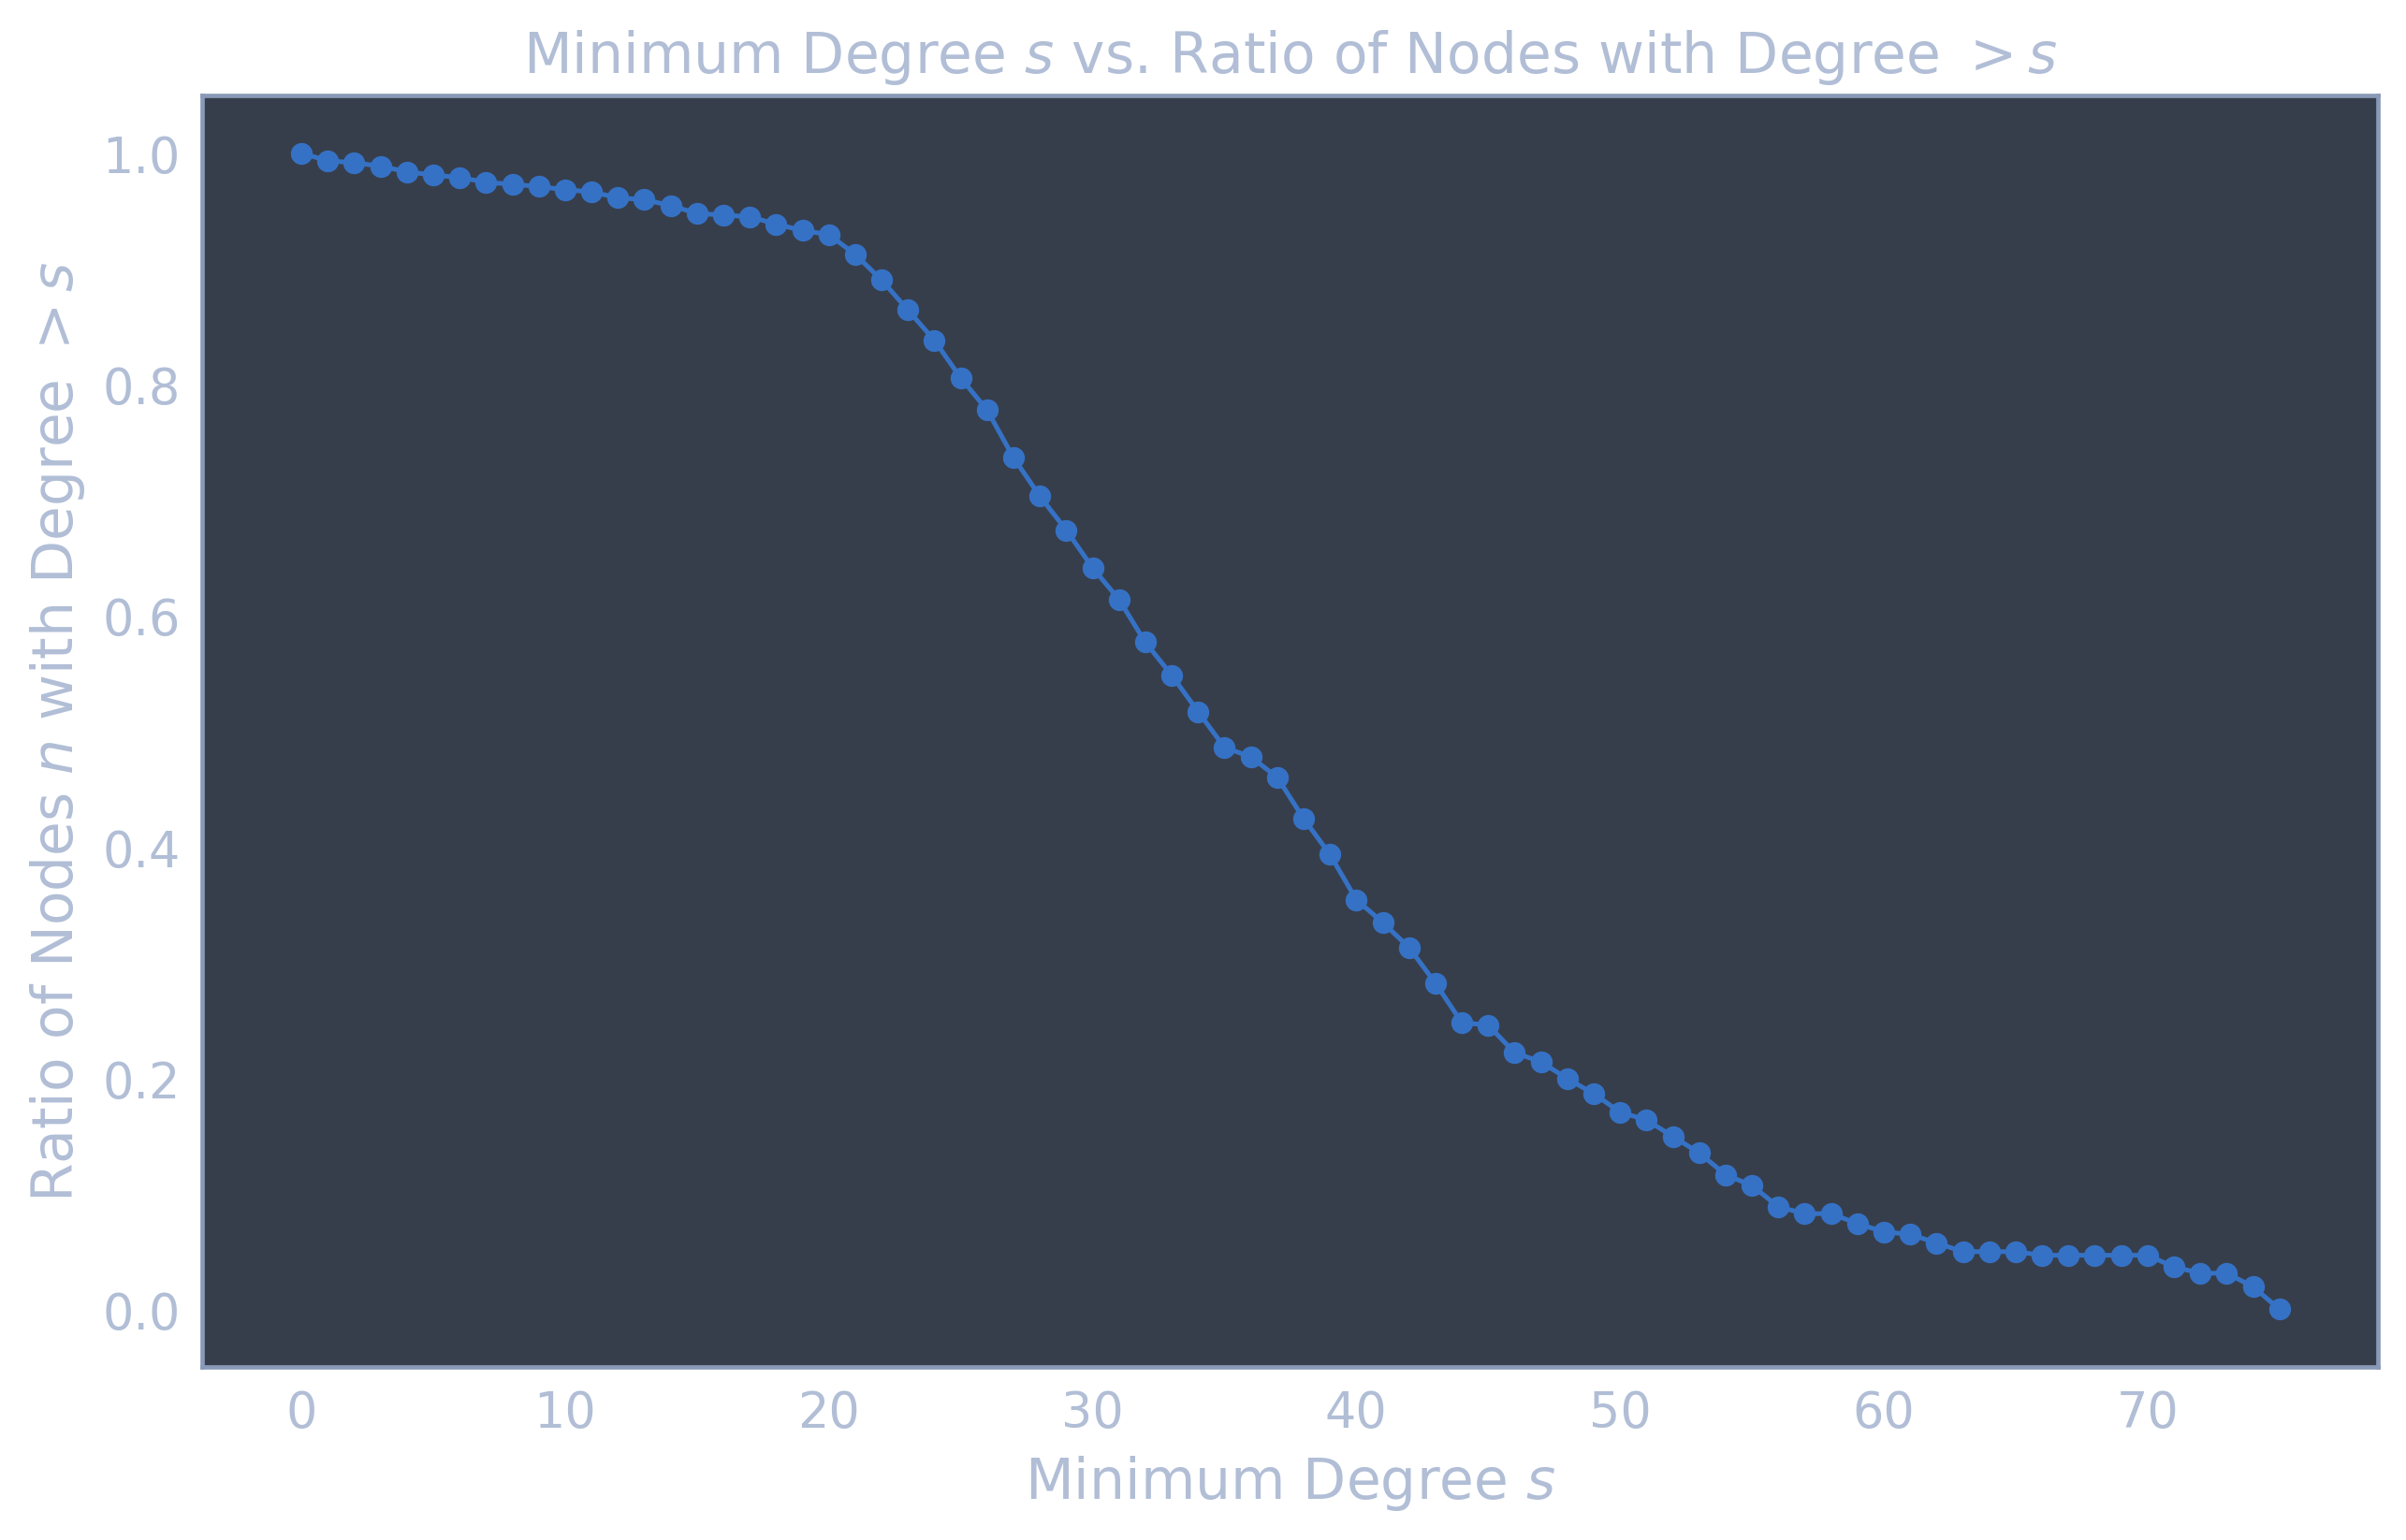

In [8]:
plt.rcParams['figure.dpi'] = 300
fig1, ax1 = plt.subplots(1, figsize = (10,6))
ax1.plot(num_connections, subgenre_lengths / subgenre_lengths[0], '-o')
ax1.set_xlabel(r'Minimum Degree $s$')
ax1.set_ylabel(r'Ratio of Nodes $n$ with Degree $>s$')
ax1.set_title(r'Minimum Degree $s$ vs. Ratio of Nodes with Degree $>s$')
ax1.grid(False)
plt.show()
fig1.savefig('./images/subgenre_connections', bbox_inches='tight')

From the plot, we can see that as the degree $s$ increases, and of course the ratio of nodes with degree $d > s$ decreases monotonically. The largest change in the ratio of nodes is from about $s = 20$ to $s = 45$. There are genres that have no similar genres on *everynoise*, so there needs to be a way to account for these and not have them by their lonesome. We can use the genres it's most opposite to and make connections between that genre, and others who share similar $OPP\_GENRES$. There are also other 'island' communities that perhaps could be connected to the main graph with that strategy as well.

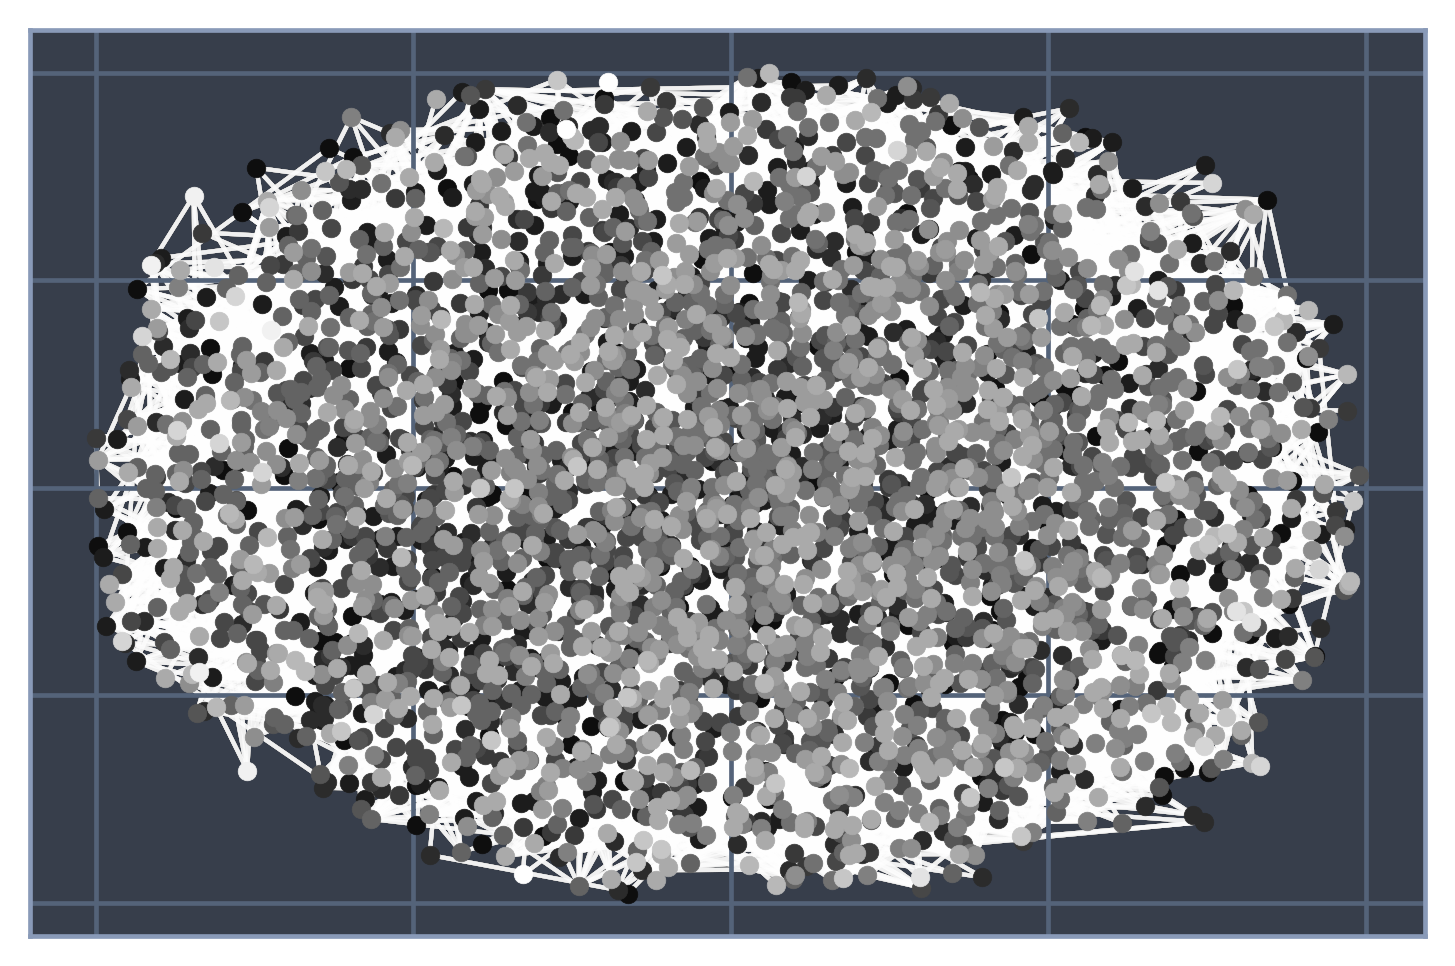

In [26]:
G1 = generate_G(df_allG, 2)
partition = community.best_partition(G1)
size = float(len(set(partition.values())))
pos = nx.spring_layout(G1,k=1,iterations=20)

count = 0
for com in set(partition.values()):
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G1, pos, list_nodes, node_size = 20, node_color = str(count / size))
    nx.draw_networkx_edges(G1, pos, edge_color = str(count / size), alpha=0.5)
plt.show()
# plot_network(G1, sub_sets[2])

# Playlist Feature Analysis

In [41]:
play_features = pd.read_csv('play_id_to_features.csv')
play_features['genre'] = df_allG['GENRE']
play_features.head()

Unnamed: 0  danceability    energy   key  loudness  mode  \
0  2JsqQdMbBC2hh7GjsEjKFg      0.222149  0.073075  4.38 -25.78303  0.66   
1  2SoQc6bippmMyUTn1qditv      0.525410  0.645390  4.22  -9.24089  0.72   
2  1KZMCWImik3vA17zVLJ3c3      0.213119  0.166708  5.39 -18.83644  0.56   
3  1i9zTcQqWUBTgIuCgxDW3S      0.439940  0.348418  5.05 -12.84006  0.71   
4  0TcXdt4sbITbwCwwFbKYyd      0.789310  0.518160  5.14 -10.01960  0.53   

   speechiness  acousticness  instrumentalness  liveness   valence      tempo  \
0     0.041801      0.922340          0.899800  0.118957  0.095634   92.38971   
1     0.083043      0.468130          0.066672  0.282273  0.695130  119.71814   
2     0.039690      0.966740          0.210298  0.152561  0.144698  102.87562   
3     0.055323      0.896280          0.855150  0.141858  0.396229  107.26951   
4     0.133222      0.148952          0.111601  0.148528  0.736290  118.49993   

   time_signature               genre  
0            3.60     backgroundmusic  
1            3.55  classicmoroccanpop  
2            3.69       orthodoxchant  
3            3.60                 tar  
4            4.00              reggae

# Feature Description

According to the Spotify Web API 
(This is just for reference and describes the meaning of the audio features used by spotify to describe tracks)

## Danceability
>	"Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable."

## Speechiness
>   "Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks."

## Energy
>   "Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy."

## Instrumentalness
>	"Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0."

## Key
> 	"The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on."

## Liveness
> 	"Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live."

## Loudness 
> 	"The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db."

## Mode
>	"Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0."

## Tempo
>	The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

## Time Signature
>	"An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure)."

## Valence
>	"A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)."


In [42]:
play_features[play_features['danceability'] == -1]

Unnamed: 0  danceability  energy  key  loudness  mode  \
634  63rahDKdDo5xjhy0DsIafA          -1.0    -1.0 -1.0      -1.0  -1.0   

     speechiness  acousticness  instrumentalness  liveness  valence  tempo  \
634         -1.0          -1.0              -1.0      -1.0     -1.0   -1.0   

     time_signature              genre  
634            -1.0  islamicrecitation

In [43]:
# -1 means the api returned some sort of error
# we will go back later and look into this error but for now remove it because it makes the graphs yucky
play_features = play_features.drop(634)

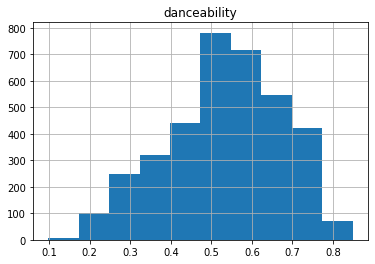

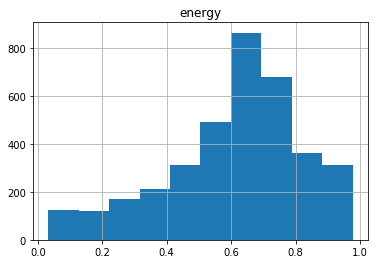

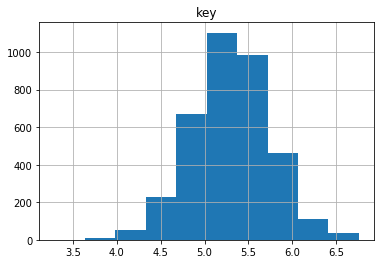

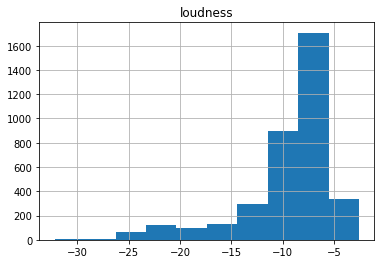

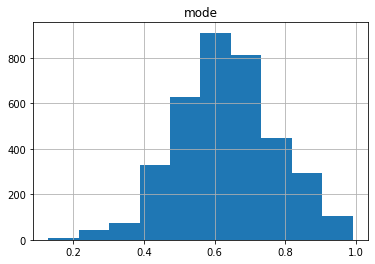

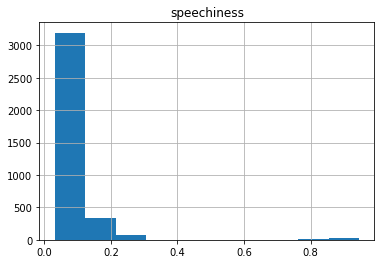

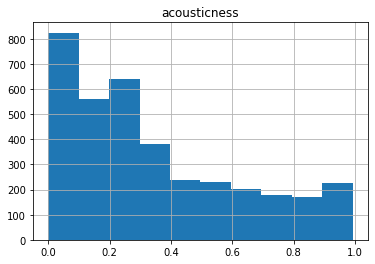

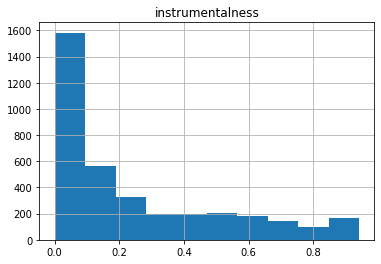

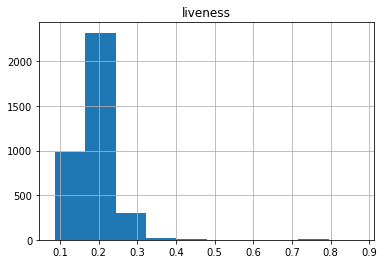

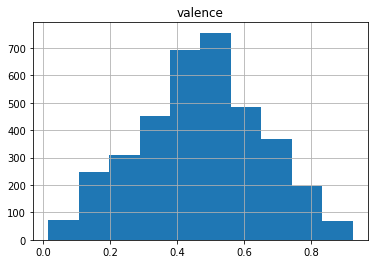

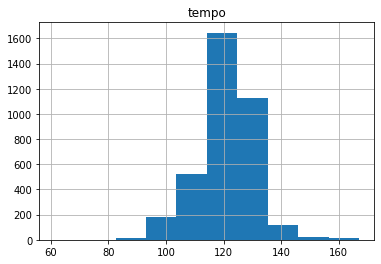

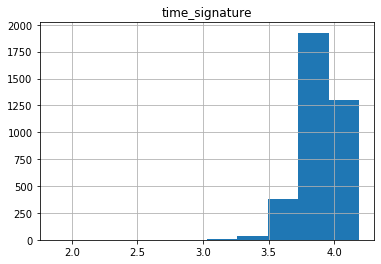

In [40]:
for f in features:
    plt.figure()
    if f == 'speechiness':
        play_features[f].hist(bins = 10)
    else:
        play_features[f].hist()
    plt.title(f)
    plt.show()

# Feature Selection

It would appear looking at the distributions of the playlist tracks average values that a few features may be less meaningful. Looking at the above, we may find it useful to throw out time-signature, instrumentalness, speechiness, liveness, and mode, because they aren't distributed in what looks like anything meaningful. 

We are planning to perform PCA or SVD to determine which features to throw out instead of solely basing it on the distributions. We will combine knowledge of the feature distribution and knowledge gained from performing PCA and SVD to decide if any features are not super useful because clustering is easier to understand with fewer features. 

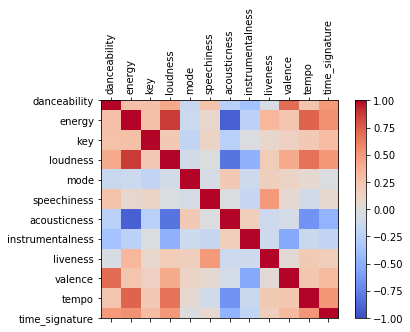

In [24]:
# https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3
data = play_features[features]
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

In [25]:
corr

danceability    energy       key  loudness      mode  \
danceability          1.000000  0.273655  0.266668  0.409840 -0.140372   
energy                0.273655  1.000000  0.280308  0.875245 -0.118703   
key                   0.266668  0.280308  1.000000  0.210908 -0.186546   
loudness              0.409840  0.875245  0.210908  1.000000 -0.074633   
mode                 -0.140372 -0.118703 -0.186546 -0.074633  1.000000   
speechiness           0.252267  0.088885  0.121701 -0.011041 -0.058428   
acousticness         -0.240482 -0.901963 -0.237872 -0.806339  0.207911   
instrumentalness     -0.359749 -0.227776 -0.022036 -0.478847 -0.112492   
liveness             -0.042185  0.333977  0.088420  0.181243  0.161502   
valence               0.702354  0.241860  0.146915  0.404053  0.122734   
tempo                 0.239839  0.730100  0.210076  0.678895  0.056894   
time_signature        0.497665  0.541326  0.295422  0.503617 -0.022449   

                  speechiness  acousticness  instrumentalness  liveness  \
danceability         0.252267     -0.240482         -0.359749 -0.042185   
energy               0.088885     -0.901963         -0.227776  0.333977   
key                  0.121701     -0.237872         -0.022036  0.088420   
loudness            -0.011041     -0.806339         -0.478847  0.181243   
mode                -0.058428      0.207911         -0.112492  0.161502   
speechiness          1.000000     -0.010669         -0.151062  0.497001   
acousticness        -0.010669      1.000000          0.166507 -0.117866   
instrumentalness    -0.151062      0.166507          1.000000 -0.112688   
liveness             0.497001     -0.117866         -0.112688  1.000000   
valence              0.069558     -0.067098         -0.538447  0.044582   
tempo               -0.084915     -0.651815         -0.130146  0.202154   
time_signature       0.073291     -0.468570         -0.188515  0.169843   

                   valence     tempo  time_signature  
danceability      0.702354  0.239839        0.497665  
energy            0.241860  0.730100        0.541326  
key               0.146915  0.210076        0.295422  
loudness          0.404053  0.678895        0.503617  
mode              0.122734  0.056894       -0.022449  
speechiness       0.069558 -0.084915        0.073291  
acousticness     -0.067098 -0.651815       -0.468570  
instrumentalness -0.538447 -0.130146       -0.188515  
liveness          0.044582  0.202154        0.169843  
valence           1.000000  0.226990        0.316006  
tempo             0.226990  1.000000        0.509584  
time_signature    0.316006  0.509584        1.000000

In [31]:
print('danceability and valence -- ' ,corr['danceability']['valence'])
print('energy and tempo -- ',corr['energy']['tempo'])
print('energy and loudness -- ',corr['energy']['loudness'])

print('energy and acousticness -- ',corr['energy']['acousticness'])
print('loudness and acousticness -- ',corr['loudness']['acousticness'])

danceability and valence --  0.7023535344309583
energy and tempo --  0.7300996278865707
energy and loudness --  0.8752448766630505
energy and acousticness --  -0.9019626557785377
loudness and acousticness --  -0.8063394007621765


# Feature Correlation

The above is a heatmap showing feature by feature correlation. 

The highest positive correlation is between energy and loudness which makes intuitive sense. A song with more loudness may be a good indicator of high energy, so we may not need to consider both of these features.
Also, energy is highly correlated with tempo, but since tempo and loudness aren't correlated as highly removing energy from consideration may be best.

The correlation between danceability and valence means that more danceable songs tend to have a more positive mood and less danceable songs have a sadder mood. I get it, I don't like to dance while I cry either!

The most highly negatively correlated features are energy and acousticness. This is interesting, not something I would have guessed as I don't tend to necessarily associate accoustic music inherently with low energy but it seems that something in how they measure and calculate both of these features may be similar. 

Finally, we can see that acousticness may mean tracks are quiter. 

In [44]:
from sklearn.cluster import KMeans
play_features.head()

Unnamed: 0  danceability    energy   key  loudness  mode  \
0  2JsqQdMbBC2hh7GjsEjKFg      0.222149  0.073075  4.38 -25.78303  0.66   
1  2SoQc6bippmMyUTn1qditv      0.525410  0.645390  4.22  -9.24089  0.72   
2  1KZMCWImik3vA17zVLJ3c3      0.213119  0.166708  5.39 -18.83644  0.56   
3  1i9zTcQqWUBTgIuCgxDW3S      0.439940  0.348418  5.05 -12.84006  0.71   
4  0TcXdt4sbITbwCwwFbKYyd      0.789310  0.518160  5.14 -10.01960  0.53   

   speechiness  acousticness  instrumentalness  liveness   valence      tempo  \
0     0.041801      0.922340          0.899800  0.118957  0.095634   92.38971   
1     0.083043      0.468130          0.066672  0.282273  0.695130  119.71814   
2     0.039690      0.966740          0.210298  0.152561  0.144698  102.87562   
3     0.055323      0.896280          0.855150  0.141858  0.396229  107.26951   
4     0.133222      0.148952          0.111601  0.148528  0.736290  118.49993   

   time_signature               genre  
0            3.60     backgroundmusic  
1            3.55  classicmoroccanpop  
2            3.69       orthodoxchant  
3            3.60                 tar  
4            4.00              reggae

In [45]:
play_features.columns

Index(['Unnamed: 0', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'genre'],
      dtype='object')

In [88]:
X = play_features[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness']].to_numpy()

In [89]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

In [90]:
sample = play_features.copy()
sample['cluster'] = kmeans.labels_

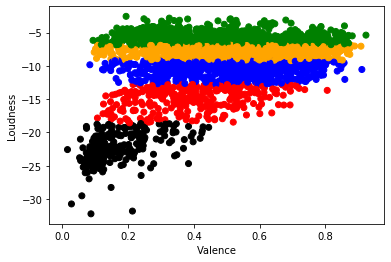

In [91]:
import matplotlib.pyplot as plt
color_map = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'orange',
    4: 'black'
}
colors = sample['cluster'].map(color_map)
plt.scatter(x = sample['valence'].values, y = sample['loudness'].values, color = colors)
plt.xlabel('Valence')
plt.ylabel('Loudness')
plt.show()

In [73]:
def plot_features(f1, f2, sample, color_map):
    colors = sample['cluster'].map(color_map)
    plt.scatter(x = sample[f1].values, y = sample[f2].values, color = colors)
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.show()

In [74]:
sample.columns

Index(['Unnamed: 0', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'genre', 'cluster'],
      dtype='object')

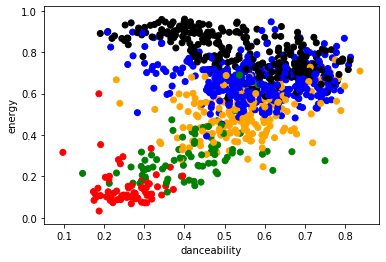

In [75]:
plot_features('danceability', 'energy', sample, color_map)

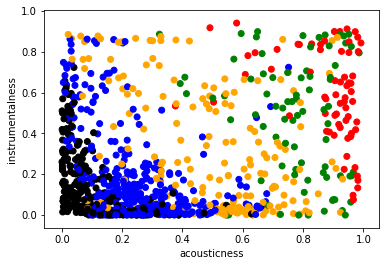

In [76]:
plot_features('acousticness', 'instrumentalness', sample, color_map)

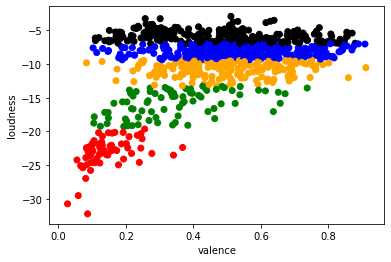

In [77]:
plot_features('valence','loudness',sample,color_map)

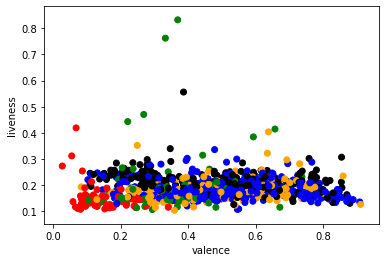

In [78]:
plot_features('valence','liveness',sample,color_map)

In [81]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
%matplotlib inline
import matplotlib.pyplot as plt

def plot_3d(f1, f2, f3, sample, colors):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = sample[f1]
    ys = sample[f2]
    zs = sample[f3]

    ax.scatter(xs, ys, zs, color = colors)

    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_zlabel(f3)

    plt.show()

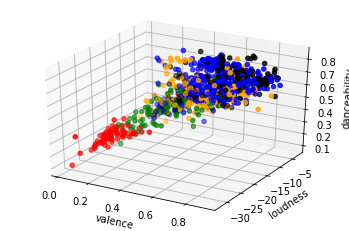

In [83]:
plot_3d('valence', 'loudness', 'danceability', sample, colors)

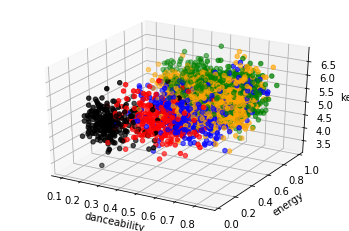

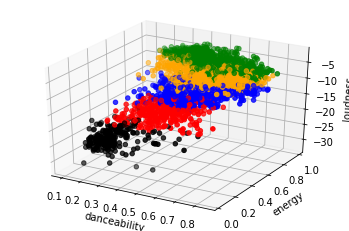

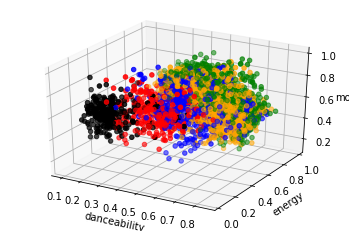

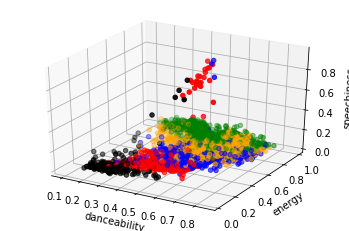

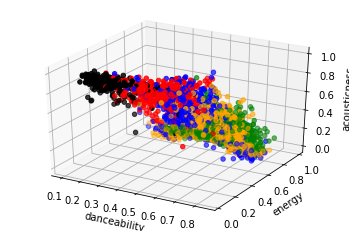

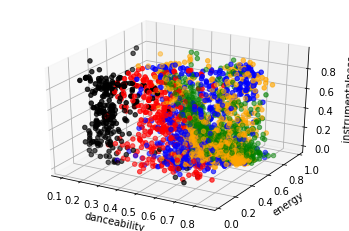

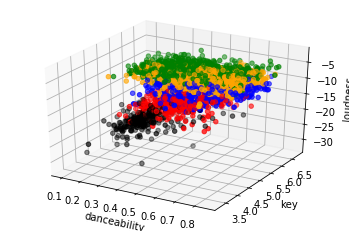

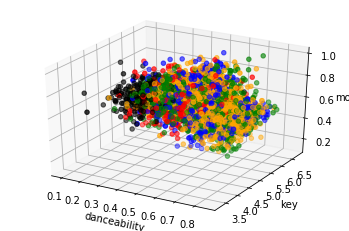

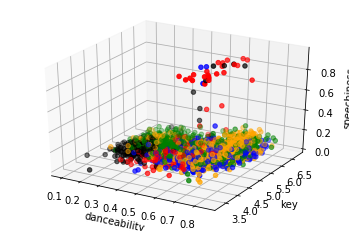

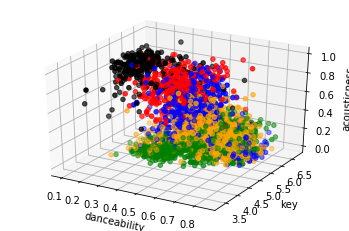

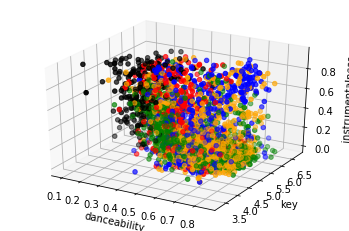

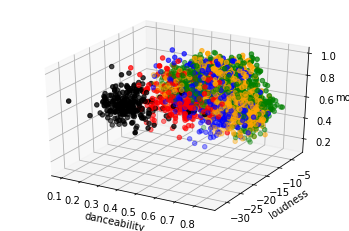

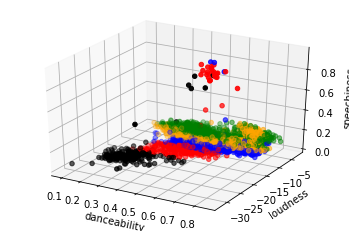

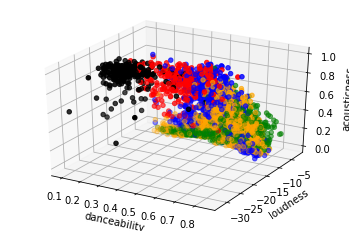

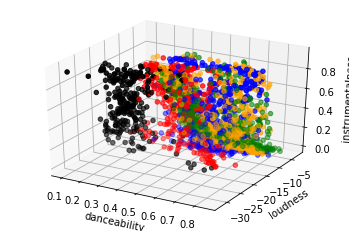

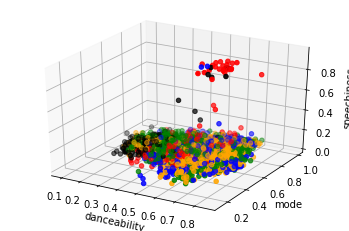

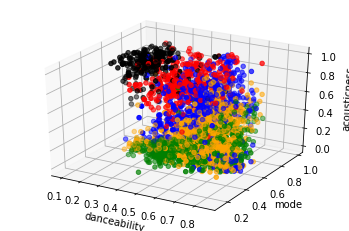

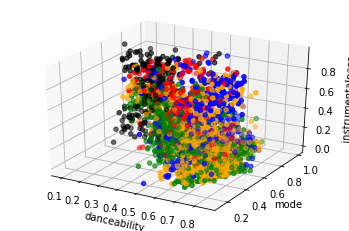

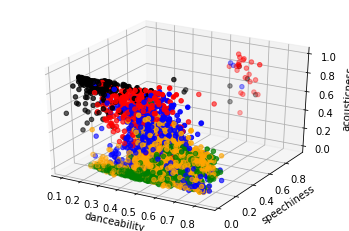

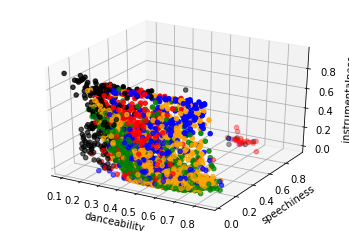

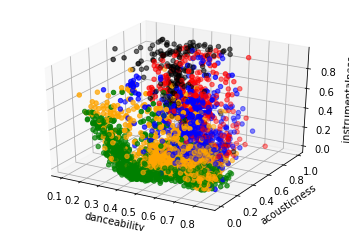

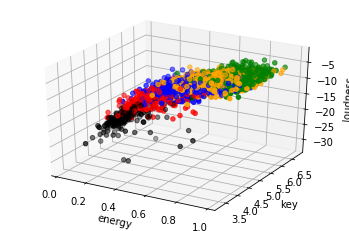

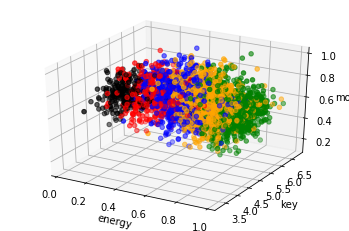

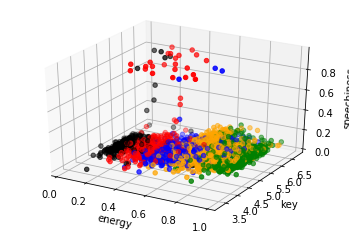

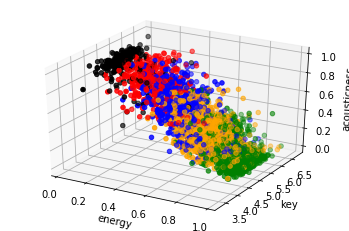

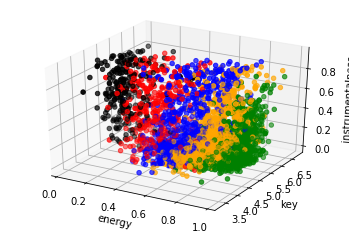

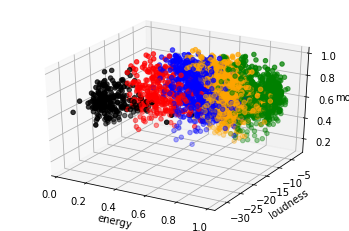

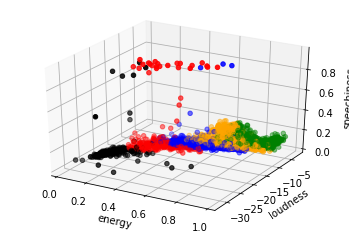

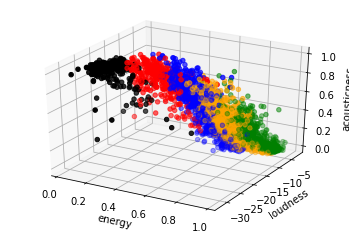

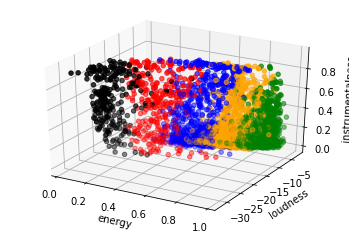

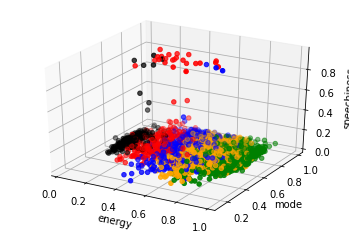

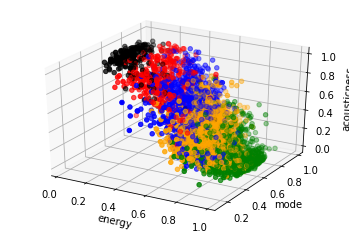

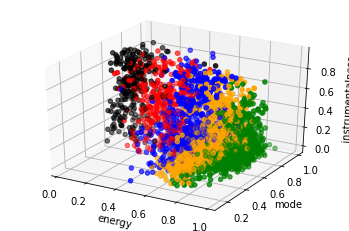

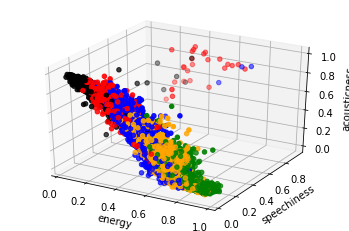

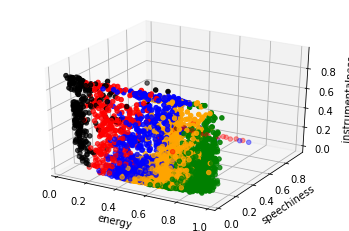

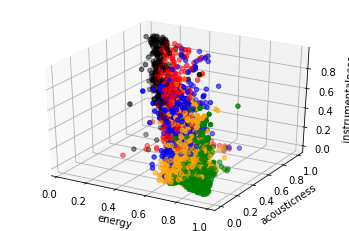

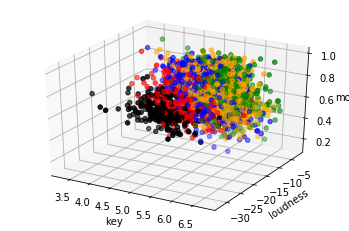

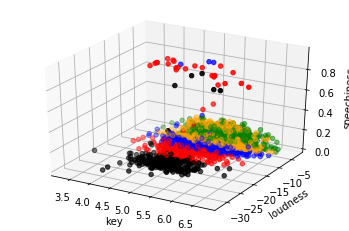

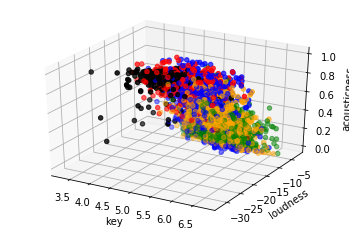

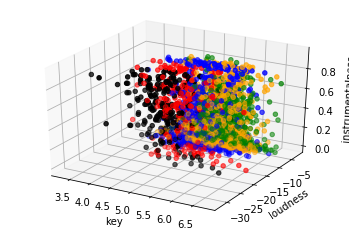

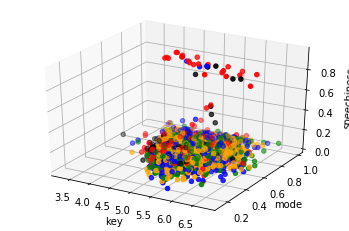

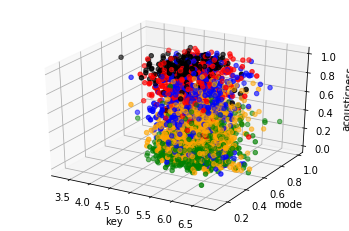

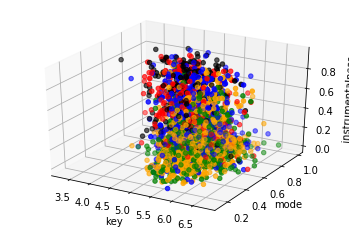

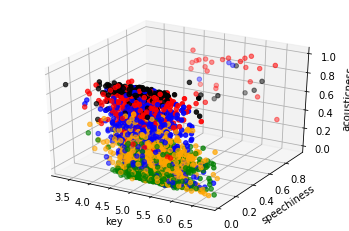

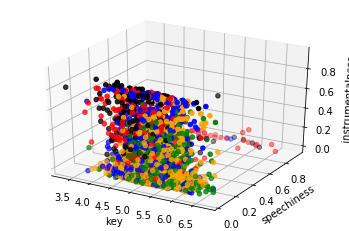

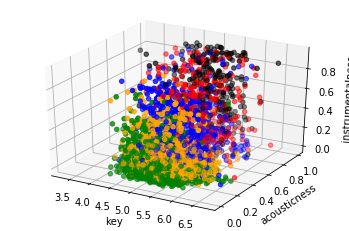

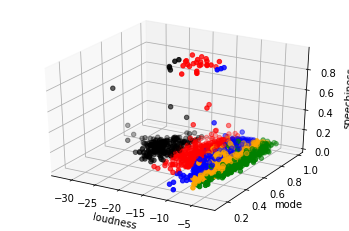

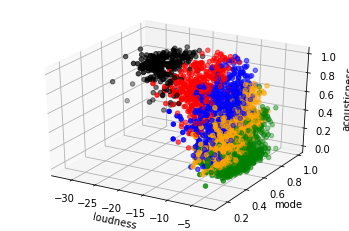

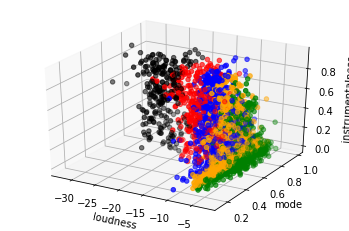

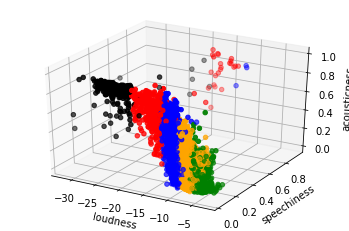

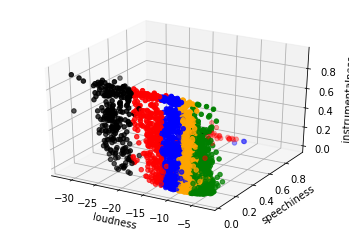

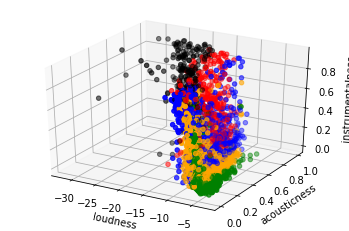

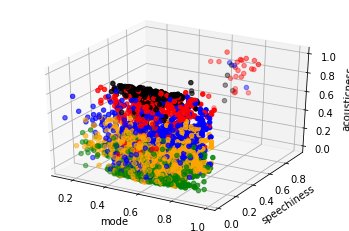

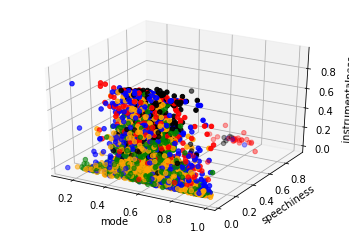

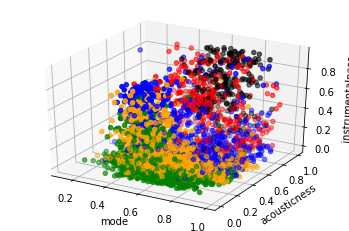

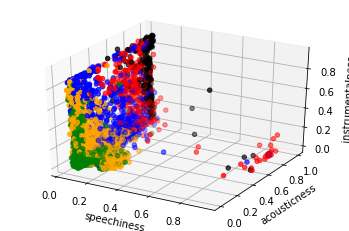

In [92]:
import itertools

features = ['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness']
for f1,f2,f3 in itertools.combinations(features, 3):
    plot_3d(f1,f2,f3,sample,colors)

In [93]:
school_genres = pd.read_csv('school_genres.csv')
school_genres.head()

Unnamed: 0                                  SCHOOL  \
0           0  Texas A & M University-College Station   
1           1       The University of Texas at Austin   
2           2       Ohio State University-Main Campus   
3           3           University of Central Florida   
4           4          Arizona State University-Tempe   

                                              GENRES  \
0  ['reddirt', 'outlawcountry', 'texascountry', '...   
1  ['modernrock', 'indiepop', 'pop', 'indiepoptim...   
2  ['pop', 'indiepoptimism', 'modernrock', 'indie...   
3  ['pop', 'poprap', 'rap', 'hiphop', 'electrohou...   
4  ['edm', 'electrohouse', 'pop', 'electronictrap...   

                                       PLAYLIST_LINK  
0  https://embed.spotify.com/?uri=spotify:playlis...  
1  https://embed.spotify.com/?uri=spotify:playlis...  
2  https://embed.spotify.com/?uri=spotify:playlis...  
3  https://embed.spotify.com/?uri=spotify:playlis...  
4  https://embed.spotify.com/?uri=spotify:playlis...

In [102]:
# Spring rank works by taking a ranking system and connecting nodes to all nodes that are below them
G = nx.Graph()
added_nodes = set({})
for idx, row in school_genres.iterrows():
    ranking = ast.literal_eval(row['GENRES'])
    rank_set = set(ranking)
    print(ranking)
    for new_top in ranking:
        print(new_top)
        if new_top not in added_nodes:
            G.add_node(new_top)
        rank_set.remove(new_top)
        print(rank_set)
        edges = [(new_top, lower_node) for lower_node in rank_set]
        G.add_edges_from(edges)
            
        # Useful if you only need a small sample (for testing mainly)
    if idx == 10:
        break

['reddirt', 'outlawcountry', 'texascountry', 'anthemworship', 'indiecoustica', 'rootsamericana', 'ccm', 'countryroad', 'moderncountryrock', 'contemporarycountry', 'worldworship', 'country', 'newamericana', 'rootsworship', 'worship', 'christianpop', 'christianuplift', 'hopebeat', 'folkpop', 'heartlandrock', 'modernrock', 'rootsrock', 'stompandholler', 'alternativecountry', 'austindie', 'christianalternativerock', 'christianmusic', 'countryrock', 'deepnewamericana', 'electropop', 'indiefolk', 'indiepoptimism', 'modernsouthernrock', 'neomellow', 'traditionalcountry']
reddirt
{'christianalternativerock', 'newamericana', 'rootsrock', 'hopebeat', 'moderncountryrock', 'indiefolk', 'electropop', 'contemporarycountry', 'christianpop', 'christianuplift', 'countryrock', 'rootsworship', 'country', 'worldworship', 'folkpop', 'austindie', 'worship', 'outlawcountry', 'indiepoptimism', 'deepnewamericana', 'christianmusic', 'ccm', 'neomellow', 'traditionalcountry', 'modernrock', 'modernsouthernrock', '

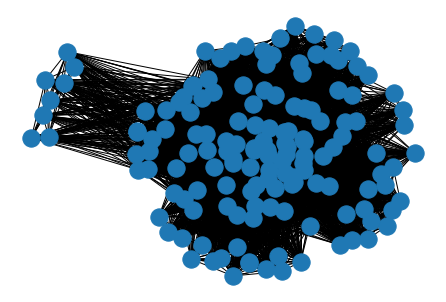

In [103]:
nx.draw(G)

In [116]:
school_genres.head()
def top_n_genres(row):
    ranking = ast.literal_eval(row)
    top = ranking[:5]
    return [str(g) for g in top]

school_genres['TOP_5'] = school_genres['GENRES'].map(top_n_genres)

In [115]:
# play_features = play_features.set_index('genre')
school = school_genres.iloc[0]
school

Unnamed: 0                                                       0
SCHOOL                      Texas A & M University-College Station
GENRES           ['reddirt', 'outlawcountry', 'texascountry', '...
PLAYLIST_LINK    https://embed.spotify.com/?uri=spotify:playlis...
TOP_5            [reddirt, outlawcountry, texascountry, anthemw...
Name: 0, dtype: object

In [119]:
import plotly.graph_objects as go

features = ['danceability', 'energy','loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness']

fig = go.Figure()

top_genres = school['TOP_5']
print(top_genres)
for genre in top_genres:
    g_feat = play_features[features].loc[genre]
    print(g_feat)
    fig.add_trace(go.Scatterpolar(
          r=g_feat,
          theta=features,
          fill='toself',
          name='Product A'
    ))

# fig.update_layout(
#   polar=dict(
#     radialaxis=dict(
#       visible=True,
#       range=[0, 5]
#     )),
#   showlegend=False
# )

fig.show()

['reddirt', 'outlawcountry', 'texascountry', 'anthemworship', 'indiecoustica']
danceability        0.531600
energy              0.638840
loudness           -6.983030
mode                0.900000
speechiness         0.036862
acousticness        0.192566
instrumentalness    0.001589
Name: reddirt, dtype: float64
danceability        0.550090
energy              0.511072
loudness           -9.808100
mode                0.840000
speechiness         0.038350
acousticness        0.406812
instrumentalness    0.024467
Name: outlawcountry, dtype: float64
danceability        0.545760
energy              0.619401
loudness           -7.457360
mode                0.910000
speechiness         0.036858
acousticness        0.249212
instrumentalness    0.012309
Name: texascountry, dtype: float64
danceability        0.434310
energy              0.532010
loudness           -8.147460
mode                0.910000
speechiness         0.041484
acousticness        0.292087
instrumentalness    0.007803
Name: an

# Work still to be done

- GMM for playlist feature data
- PCA and SVD, remove some features from playlist features
- SpringRank Hamiltonian on school genres to find most popular genres across colleges in US
- compare clustering to community detection algorithms
- lots of analysis
- possibly take subsets of most commonly known/popular genres to get more intuitive understanding of what the algorithms are doing